In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
data = np.genfromtxt('MDA2_data/Gasch_200genes.txt')

In [4]:
data

array([[-0.62, -0.51,  0.18, ...,  0.29,  0.04,   nan],
       [-0.4 , -0.2 , -0.6 , ...,  0.16, -0.18,   nan],
       [-0.6 ,  0.03,  0.42, ...,  0.38, -0.1 ,  0.1 ],
       ...,
       [-0.38, -1.18, -0.54, ...,  0.19,  0.08,  0.01],
       [-0.36, -1.06, -0.14, ...,  0.  , -0.27, -0.2 ],
       [-0.54, -1.89, -0.86, ...,  0.58,  0.32, -0.58]])

In [5]:
def MI(gene1, gene2, Nbins, e = 10**(-10)):
    indeces = (~np.isnan(gene1))&(~np.isnan(gene2))
    gene1 = gene1[indeces]
    gene2 = gene2[indeces]
    x_edges = np.array([np.percentile(gene1, x) for x in np.linspace(0,100,Nbins)])
    y_edges = np.array([np.percentile(gene2, x) for x in np.linspace(0,100,Nbins)])
    Px, _ = np.histogram(gene1, bins = x_edges)
    Py, _ = np.histogram(gene2, bins = y_edges)
    Pxy, _,_ = np.histogram2d(gene1, gene2, bins = (x_edges, y_edges))
    Px_norm = Px/sum(Px)
    Py_norm = Py/sum(Py)
    Pxy_norm = Pxy/sum(sum(Pxy))
    mi = 0
    for x in range(Nbins-1):
        for y in range(Nbins-1):
            if Px_norm[x] == 0: Px_norm[x] = e
            if Py_norm[y] == 0: Py_norm[y] = e
            if Pxy_norm[x,y] == 0: continue
            mi += Pxy_norm[x,y]*np.log2(Pxy_norm[x,y]/(Px_norm[x]*Py_norm[y]))
    return mi

In [6]:
def direct_mi(gene1, gene2, fractions, Nbins, e = 10**(-6), plot = False):
    indeces = (~np.isnan(gene1))&(~np.isnan(gene2))
    x = np.around(len(gene1[indeces])*fractions)
    curr_mi = np.empty(len(fractions))
    for i,f in enumerate(fractions):
        curr_mi[i] = MI(gene1[:int(np.around(len(gene1)*f))],gene2[:int(np.around(len(gene2)*f))], Nbins, e)
    k,b = np.polyfit(1/x, curr_mi, 1)
    if plot:
        plt.plot(1/x, curr_mi, label = 'naive')
        plt.plot(1/x, k/x+b, label = 'linear fit')
        plt.legend()
        plt.xlim(0)
    return b

In [7]:
def cor(gene1, gene2):
    indeces = (~np.isnan(gene1))&(~np.isnan(gene2))
    return stats.pearsonr(gene1[indeces],gene2[indeces])[0]

In [8]:
fraction = np.array([1/x for x in np.arange(1,3,0.2)])
Nbins = 5
mi = MI(gene1, gene2, 10)
dir_mi = direct_mi(gene1, gene2, fractions = fraction, Nbins = Nbins, plot = True)
print(mi, dir_mi)

NameError: name 'gene1' is not defined

In [9]:
data.shape

(200, 173)

In [10]:
Nbins = 5
Npairs = 1000
fraction = np.array([1/x for x in np.arange(1,3,0.2)])
np.random.seed(100)

mi_naive = np.empty((data.shape[0],data.shape[0]))
mi_dir = np.empty((data.shape[0],data.shape[0]))
cors = np.empty((data.shape[0],data.shape[0]))

# mi_naive = np.empty(Npairs)
# mi_dir = np.empty(Npairs)
# cors = np.empty(Npairs)
#for i in range(Npairs):
    #i1 = np.random.choice(data.shape[0])
    #i2 = np.random.choice(data.shape[0])
for i1 in range(data.shape[0]):
    for i2 in range(data.shape[0]):
        mi_naive[i1][i2] = MI(data[i1], data[i2], Nbins = Nbins)
        mi_dir[i1][i2] = direct_mi(data[i1], data[i2], Nbins = Nbins, fractions = fraction)
        cors[i1][i2] = cor(data[i1],data[i2]) 

In [11]:
mi_naive.shape

(200, 200)

/Users/ekaterinamaksimova/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


Text(0.5, 0, 'Correlation coefficient (Pearson r)')

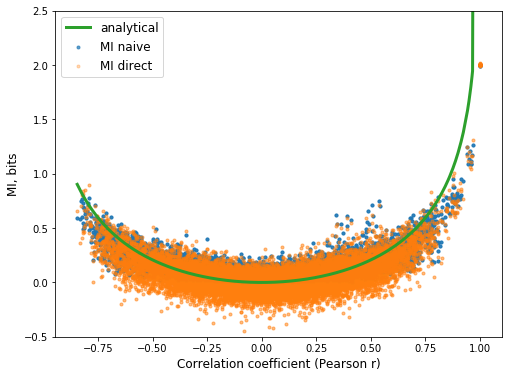

In [12]:
plt.figure(figsize = (8,6))
plt.scatter(cors.flatten(), mi_naive.flatten(), label = 'MI naive', marker = '.', alpha = 0.7)
plt.scatter(cors.flatten(), mi_dir.flatten(), label = 'MI direct', marker = '.', alpha = 0.3)
plt.plot(np.sort(cors.flatten()),-0.5*np.log2(1-np.sort(cors.flatten())**2), 
         label = 'analytical', color = 'tab:green', lw = 3)
plt.ylim(-0.5,2.5)
# plt.xlim(-0.4,0.6)
plt.legend(fontsize = 12)
plt.ylabel('MI, bits', fontsize = 12)
plt.xlabel('Correlation coefficient (Pearson r)', fontsize = 12)

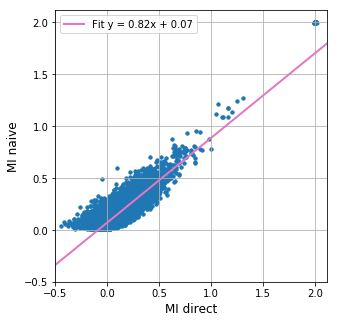

In [13]:
k,b = np.polyfit(mi_dir.flatten(), mi_naive.flatten(), 1)
max_x = max(max(mi_naive.flatten()), max(mi_dir.flatten()))
x = np.linspace(-0.5,max_x+0.1, 50)

plt.figure(figsize = (5,5))
plt.scatter(mi_dir.flatten(), mi_naive.flatten(), marker = '.')
plt.plot(x, k*x+b, label = 'Fit y = {:.2f}x + {:.2f}'.format(k,b), color = 'tab:pink', ls = '-', lw = 2)

plt.legend()
plt.ylabel('MI naive', fontsize = 12)
plt.xlabel('MI direct', fontsize = 12)
plt.xlim(-0.5,max_x+0.1)
plt.ylim(-0.5,max_x+0.1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#### Typical characteristics

In [14]:
print('Naive: mean {:.4f}, median {:.4f}, max {:.4f}'.format(np.mean(mi_naive.flatten()), 
                                                             np.median(mi_naive.flatten()), max(mi_naive.flatten())))
print('Direct: mean {:.4f}, median {:.4f}, max {:.4f}'.format(np.mean(mi_dir.flatten()),
                                                              np.median(mi_dir.flatten()), max(mi_dir.flatten())))

Naive: mean 0.1220, median 0.0821, max 2.0000
Direct: mean 0.0616, median 0.0333, max 2.0199


#### Find weird data

In [15]:
weirdos1 = []
weirdos2 = []
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        if (np.abs(cors[i][j])<0.05) & (mi_dir[i][j]>0.24):
            if (j,i) in weirdos1: continue
            weirdos1.append((i,j))
        if (np.abs(cors[i][j])>0.6) & (np.abs(mi_dir[i][j])<0.0085) & (np.abs(mi_dir[i][j])>0):
            if (j,i) in weirdos2: continue
            weirdos2.append((i,j))

In [16]:
print(weirdos1)
print(weirdos2)

[(97, 196), (156, 184)]
[(31, 67), (186, 189)]


Text(0.5, 0, 'Gene 2')

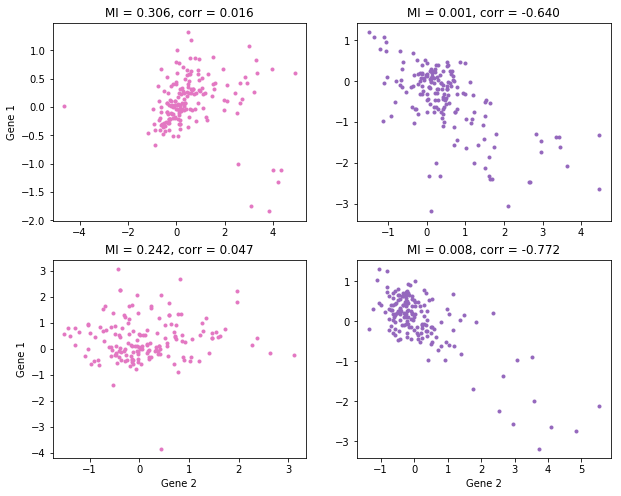

In [18]:
fig,ax = plt.subplots(2,2, figsize = (10,8))

ax[0][0].scatter(data[weirdos1[0][0],:], data[weirdos1[0][1],:], marker = '.', color = 'tab:pink')
ax[0][0].set_title('MI = {:.3f}, corr = {:.3f}'.format(mi_dir[weirdos1[0][0], weirdos1[0][1]], 
                                                    cors[weirdos1[0][0], weirdos1[0][1]]))
ax[1][0].scatter(data[weirdos1[1][0],:], data[weirdos1[1][1],:], marker = '.',color = 'tab:pink')
ax[1][0].set_title('MI = {:.3f}, corr = {:.3f}'.format(mi_dir[weirdos1[1][0], weirdos1[1][1]], 
                                                    cors[weirdos1[1][0], weirdos1[1][1]]))
ax[0][1].scatter(data[weirdos2[0][0],:], data[weirdos2[0][1],:], marker = '.',color = 'tab:purple')
ax[0][1].set_title('MI = {:.3f}, corr = {:.3f}'.format(mi_dir[weirdos2[0][0], weirdos2[0][1]], 
                                                    cors[weirdos2[0][0], weirdos2[0][1]]))
ax[1][1].scatter(data[weirdos2[1][0],:], data[weirdos2[1][1],:], marker = '.',color = 'tab:purple')
ax[1][1].set_title('MI = {:.3f}, corr = {:.3f}'.format(mi_dir[weirdos2[1][0], weirdos2[1][1]], 
                                                    cors[weirdos2[1][0], weirdos2[1][1]]))
ax[0][0].set_ylabel('Gene 1')
ax[1][0].set_ylabel('Gene 1')
ax[1][0].set_xlabel('Gene 2')
ax[1][1].set_xlabel('Gene 2')

In [160]:
# data[weirdos1[1][0],:]